In [1]:
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime as dt

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.utils import DataTypeWarning

# benchmark stuff
from buildings_bench.data import load_pandas_dataset, benchmark_registry
from buildings_bench.evaluation.managers import DatasetMetricsManager
from buildings_bench import BuildingTypes

import torch
import shap


lag = 168

/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DataTypeWarning

skforecast.exceptions.exceptions.DataTypeWarning

In [3]:
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
import warnings
warnings.filterwarnings('ignore')

In [4]:
dataset_path = Path('/projects/foundation/eulp/BuildingsBench/')

In [5]:
metrics_manager = DatasetMetricsManager()

benchmark_registry = ['smart']

In [6]:
dataset = 'smart'

In [7]:
dataset_generator = load_pandas_dataset('smart', dataset_path)

In [8]:
dataset_generator.building_type

'residential'

In [9]:
building_types_mask = (BuildingTypes.RESIDENTIAL_INT * torch.ones([1,24,1])).bool()

In [10]:
for building_name, bldg_df in dataset_generator:
    if building_name == 'HomeG':
        break
    # print(building_name)

In [11]:
bldg_df

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 01:00:00,4.966291,0.258819,9.659258e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 02:00:00,4.705276,0.500000,8.660254e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 03:00:00,4.914024,0.707107,7.071068e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 04:00:00,5.115445,0.866025,5.000000e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 05:00:00,7.676648,0.965926,2.588190e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 18:00:00,6.158514,-1.000000,-1.836970e-16,-2.449294e-16,1.000000,False,False,False,True,False,...,False,False,False,False,False,False,False,True,True,False
2016-12-15 19:00:00,7.938484,-0.965926,2.588190e-01,-2.449294e-16,1.000000,False,False,False,True,False,...,False,False,False,False,False,False,False,True,True,False
2016-12-15 20:00:00,8.552090,-0.866025,5.000000e-01,-2.449294e-16,1.000000,False,False,False,True,False,...,False,False,False,False,False,False,False,True,True,False


In [12]:
from datetime import timezone, timedelta
def get_weather_pandas(path_to_csv: str) -> pd.DataFrame:
    weather_data = pd.read_csv(path_to_csv)
    
    # Unix timestamp to UTC-5
    weather_data['time'] = weather_data['time'].apply(lambda x: (dt.fromtimestamp(x, timezone.utc) - timedelta(hours=5)).strftime('%Y-%m-%d %H:%M:%S'))
    
    weather_data.rename(columns={'time' : 'timestamp'}, inplace=True)
    weather_data = weather_data.set_index('timestamp')
    weather_data.index = pd.to_datetime(weather_data.index, format='%Y-%m-%d %H:%M:%S')
    
    assert weather_data[weather_data.index.duplicated()].empty # making sure there's no duplicates
    
    return weather_data

In [13]:
# weather_data = pd.read_csv('weather_homeB.csv')
weather_2016 = get_weather_pandas('HomeG/homeG2016.csv')
# weather_2015 = get_weather_pandas('HomeB2015.csv')
# weather_2014 = get_weather_pandas('HomeB2014.csv')
weather_data = weather_2016

In [14]:
weather_data

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
timestamp,,,,,,,,,,,,,
2016-01-01 00:00:00,36.31,clear-night,0.61,10.00,Clear,29.70,1016.82,8.72,NaN,281.0,0.0,24.15,0.0
2016-01-01 01:00:00,36.06,partly-cloudy-night,0.60,10.00,Mostly Cloudy,29.52,1016.17,8.49,0.82,284.0,0.0,23.71,0.0
2016-01-01 02:00:00,35.57,clear-night,0.61,10.00,Clear,29.29,1015.96,7.84,NaN,279.0,0.0,23.56,0.0
2016-01-01 03:00:00,35.41,clear-night,0.62,10.00,Clear,30.48,1015.98,5.75,NaN,267.0,0.0,23.89,0.0
2016-01-01 04:00:00,35.62,partly-cloudy-night,0.62,10.00,Mostly Cloudy,29.70,1015.79,7.25,0.75,267.0,0.0,24.08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,30.08,clear-night,0.70,10.00,Clear,25.21,1028.01,4.61,0.02,302.0,0.0,21.40,0.0
2016-12-31 20:00:00,26.83,clear-night,0.77,10.00,Clear,26.83,1029.03,1.44,0.01,317.0,0.0,20.73,0.0
2016-12-31 21:00:00,24.66,clear-night,0.82,10.00,Clear,18.46,1030.12,5.00,0.00,310.0,0.0,19.87,0.0


In [15]:
weather_data[['temperature', 'humidity', 'cloudCover', 'windBearing', 'pressure']]

,temperature,humidity,cloudCover,windBearing,pressure
timestamp,,,,,
2016-01-01 00:00:00,36.31,0.61,NaN,281.0,1016.82
2016-01-01 01:00:00,36.06,0.60,0.82,284.0,1016.17
2016-01-01 02:00:00,35.57,0.61,NaN,279.0,1015.96
2016-01-01 03:00:00,35.41,0.62,NaN,267.0,1015.98
2016-01-01 04:00:00,35.62,0.62,0.75,267.0,1015.79
...,...,...,...,...,...
2016-12-31 19:00:00,30.08,0.70,0.02,302.0,1028.01
2016-12-31 20:00:00,26.83,0.77,0.01,317.0,1029.03
2016-12-31 21:00:00,24.66,0.82,0.00,310.0,1030.12


In [20]:
bldg_df_1 = bldg_df.join(weather_data[['temperature', 'humidity', 'cloudCover', 'windBearing', 'pressure']])

In [17]:
bldg_df_1 = bldg_df_1.dropna()

In [21]:
bldg_df_1

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True,temperature,humidity,cloudCover,windBearing,pressure
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 01:00:00,4.966291,0.258819,9.659258e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,36.06,0.60,0.82,284.0,1016.17
2016-01-01 02:00:00,4.705276,0.500000,8.660254e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,35.57,0.61,NaN,279.0,1015.96
2016-01-01 03:00:00,4.914024,0.707107,7.071068e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,35.41,0.62,NaN,267.0,1015.98
2016-01-01 04:00:00,5.115445,0.866025,5.000000e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,35.62,0.62,0.75,267.0,1015.79
2016-01-01 05:00:00,7.676648,0.965926,2.588190e-01,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,True,False,35.34,0.64,0.00,266.0,1015.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 18:00:00,6.158514,-1.000000,-1.836970e-16,-2.449294e-16,1.000000,False,False,False,True,False,...,False,False,True,True,False,16.95,0.52,0.31,265.0,1012.12
2016-12-15 19:00:00,7.938484,-0.965926,2.588190e-01,-2.449294e-16,1.000000,False,False,False,True,False,...,False,False,True,True,False,17.38,0.53,0.73,259.0,1012.47
2016-12-15 20:00:00,8.552090,-0.866025,5.000000e-01,-2.449294e-16,1.000000,False,False,False,True,False,...,False,False,True,True,False,16.97,0.61,0.13,269.0,1013.03


In [22]:
bldg_df_1.index

DatetimeIndex(['2016-01-01 01:00:00', '2016-01-01 02:00:00',
               '2016-01-01 03:00:00', '2016-01-01 04:00:00',
               '2016-01-01 05:00:00', '2016-01-01 06:00:00',
               '2016-01-01 07:00:00', '2016-01-01 08:00:00',
               '2016-01-01 09:00:00', '2016-01-01 10:00:00',
               ...
               '2016-12-15 13:00:00', '2016-12-15 14:00:00',
               '2016-12-15 15:00:00', '2016-12-15 16:00:00',
               '2016-12-15 17:00:00', '2016-12-15 18:00:00',
               '2016-12-15 19:00:00', '2016-12-15 20:00:00',
               '2016-12-15 21:00:00', '2016-12-15 22:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8398, freq='H')

In [23]:
def train_loop(df: pd.DataFrame):
    bldg_train, bldg_test = train_test_split(df, test_size=0.25, shuffle=False)
    forecaster = ForecasterAutoreg(
        regressor        = LGBMRegressor(max_depth=-1, n_estimators=100, n_jobs=24),
        lags             = lag
    )
    forecaster.fit(
        y               = bldg_train['power'],
        exog            = bldg_train[[key for key in bldg_train.keys() if key != 'power']]
    )    
    print(f'fit lightgbm to {building_name} training start {bldg_train.index[0]} end {bldg_train.index[-1]}')
    metrics_manager = DatasetMetricsManager()
    metrics_manager.add_building_to_dataset_if_missing(
        dataset, f'{building_name}')

    pred_days = (len(bldg_test) - lag - 24) // 24

    #maes = []
    for i in range(pred_days):

        seq_ptr =lag + 24 * i

        last_window  = bldg_test.iloc[seq_ptr - lag : seq_ptr]
        ground_truth = bldg_test.iloc[seq_ptr : seq_ptr + 24]

        predictions = forecaster.predict(
            steps       = 24,
            last_window = last_window['power'],
            exog        = ground_truth[[key for key in bldg_test.keys() if key != 'power']]
        )

        #mae = np.mean(abs(ground_truth['power'].values - predictions.values))
        #maes += [mae]
        metrics_manager(
            dataset,
            f'{building_name}',
            torch.from_numpy(ground_truth['power'].values).float().view(1,24,1),
            torch.from_numpy(predictions.values).float().view(1,24,1),
            building_types_mask
        )  
        
    forecaster.regressor.fit(bldg_train[[key for key in bldg_train.keys() if key != 'power']], bldg_train['power'])
    explainer = shap.TreeExplainer(forecaster.regressor)
    # shap_values = explainer.shap_values(bldg_test[[key for key in bldg_test.keys() if key != 'power']])
        
    return metrics_manager.summary()['value'][0], explainer, bldg_test[[key for key in bldg_test.keys() if key != 'power']]

In [24]:
res, explainer, valid_x = train_loop(bldg_df_1)
res

fit lightgbm to HomeG training start 2016-01-01 01:00:00 end 2016-09-19 10:00:00


0.4334971010684967

In [63]:
res, _, _ = train_loop(bldg_df_1.drop(columns=['temperature', 'humidity', 'cloudCover', 'windBearing', 'pressure']))
res

fit lightgbm to HomeG training start 2016-01-01 01:00:00 end 2016-09-19 10:00:00


0.4928204119205475

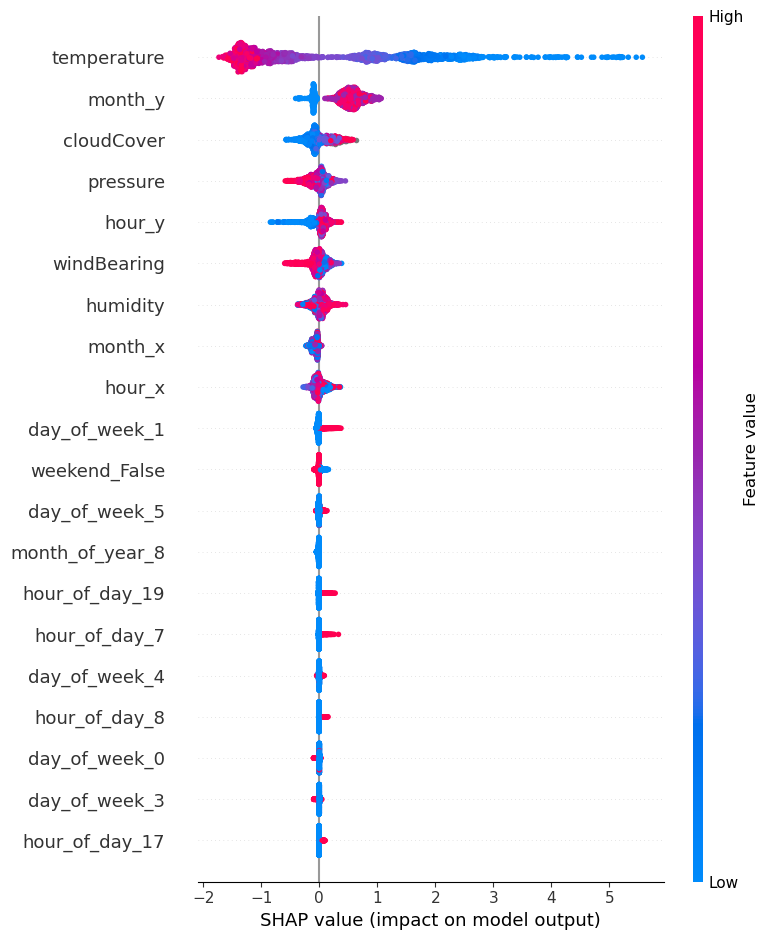

In [25]:
shap_values = explainer.shap_values(valid_x)
shap.summary_plot(shap_values, valid_x)

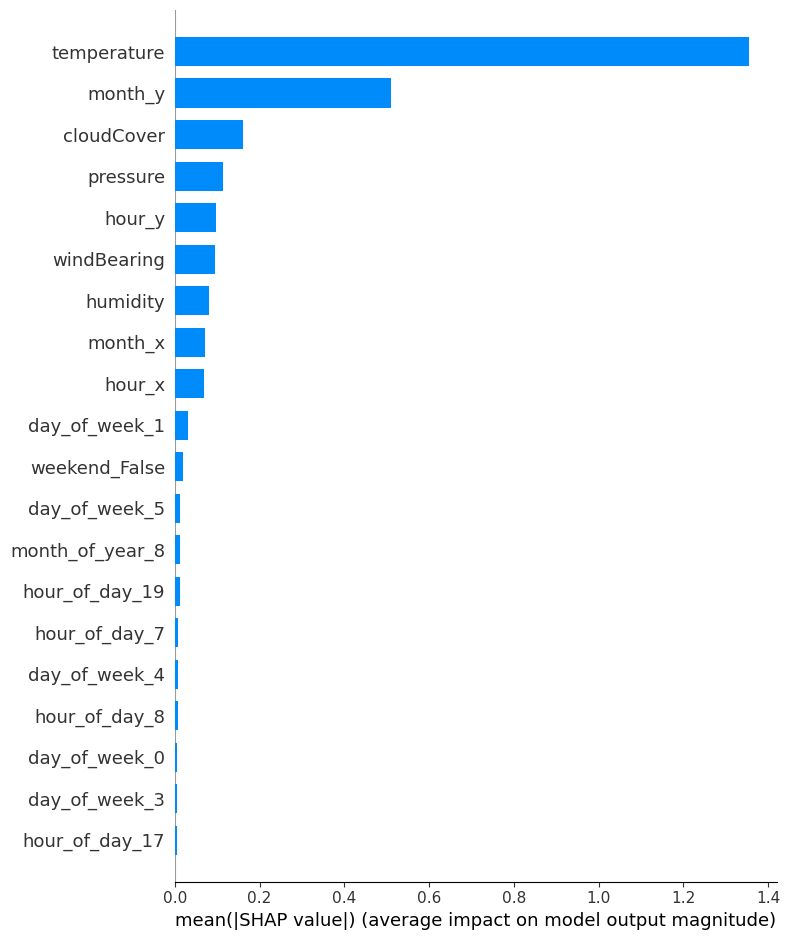

In [26]:
shap.summary_plot(shap_values, valid_x, plot_type='bar')

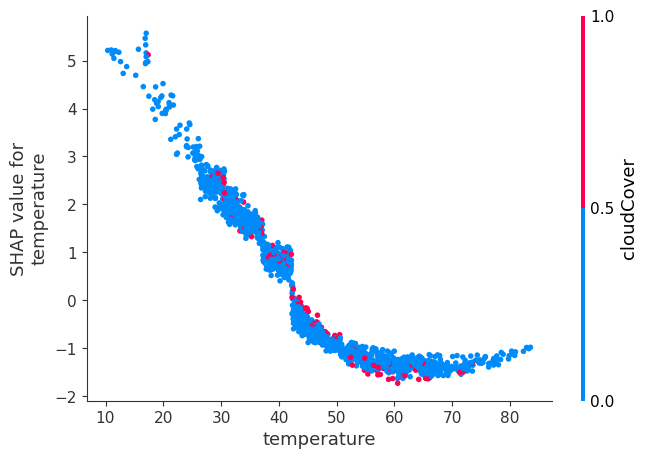

In [65]:
shap.dependence_plot("temperature", shap_values, valid_x, interaction_index="cloudCover")

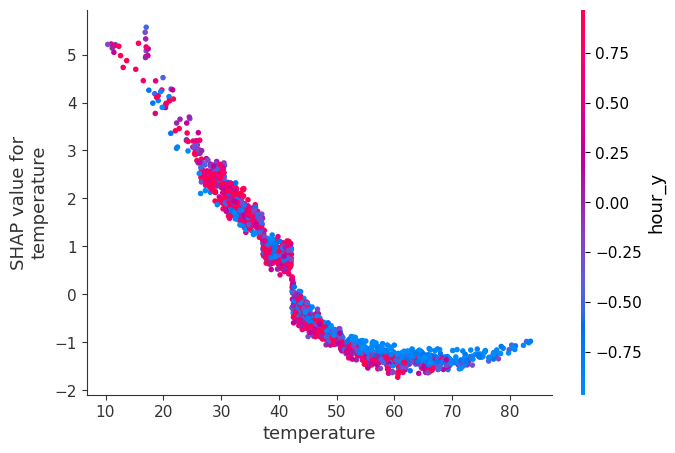

In [28]:
shap.dependence_plot("temperature", shap_values, valid_x, interaction_index="hour_y")

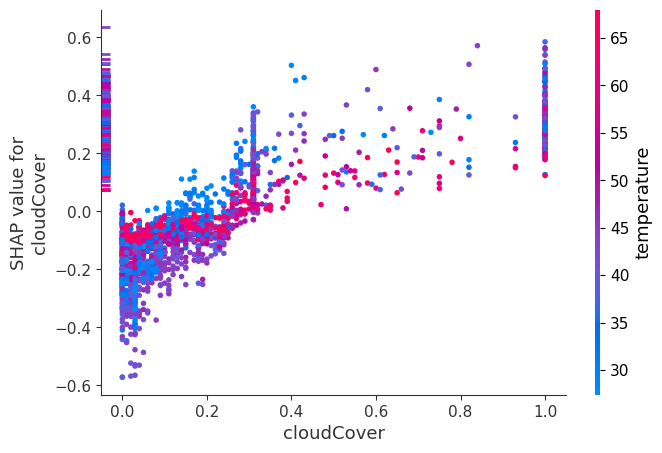

In [66]:
shap.dependence_plot("cloudCover", shap_values, valid_x)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [31]:
df = bldg_df_1[['power', 'temperature']]

In [32]:
cormat = bldg_df_1.corr()

In [33]:
cormat.head(1)

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True,temperature,humidity
power,1.0,0.076998,0.126446,0.391922,0.534095,0.019402,0.010556,-0.025529,-0.02661,-0.002618,...,-0.192835,-0.167884,-0.216339,-0.093256,0.066953,0.197774,-0.019201,0.019201,-0.742165,0.004429


Text(0, 0.5, 'pearson')

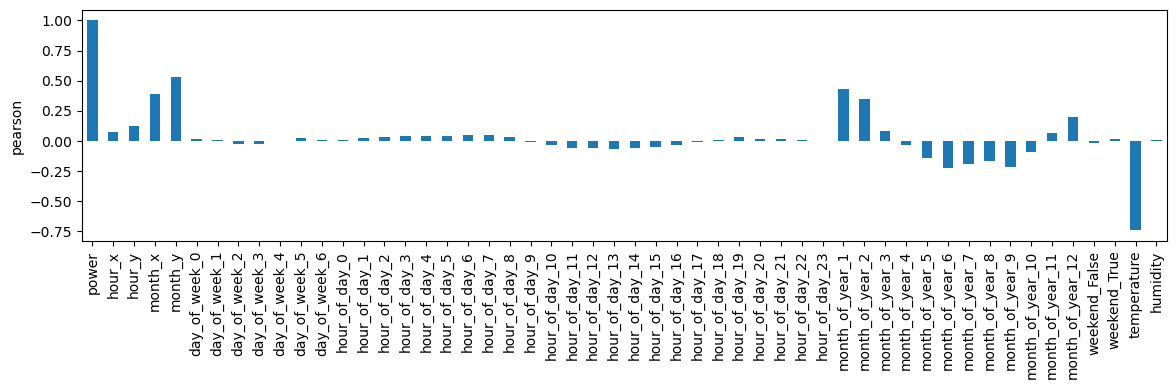

In [36]:
f,ax=plt.subplots(figsize=(14,3))
cormat.iloc[0].plot(kind='bar', ax=ax)
ax.set_ylabel('pearson')

In [37]:
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")

Pandas computed Pearson r: -0.742164581914445


In [38]:
r, p = stats.pearsonr(df['power'], df['temperature'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.7421645819144489 and p-value: 0.0


In [39]:
df.corr()

,power,temperature
power,1.000000,-0.742165
temperature,-0.742165,1.000000


In [40]:
import numpy as np

[Text(0.5, 1.0, 'Overall Pearson r = -0.74')]

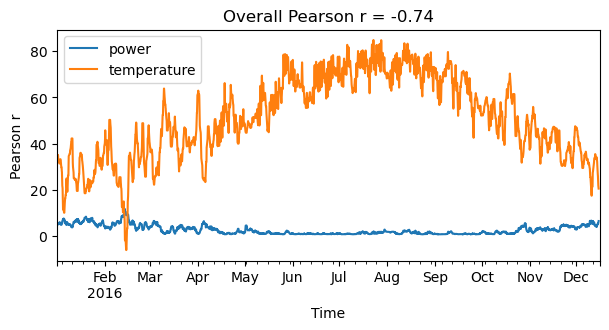

In [41]:
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}")

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Pearson r')]

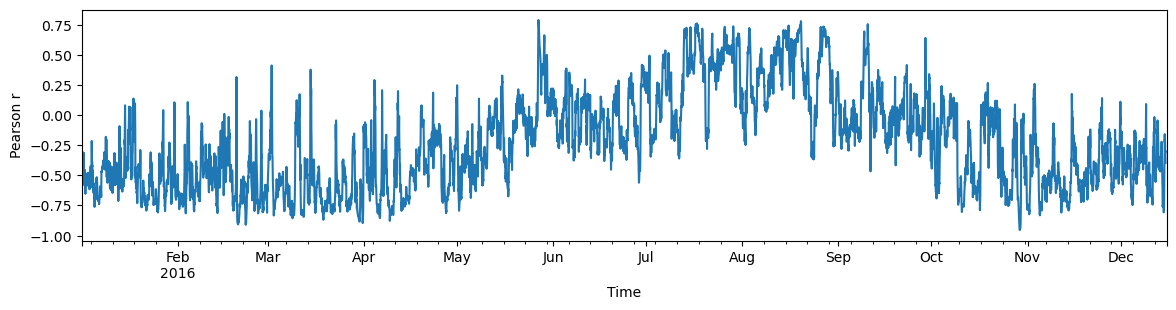

In [42]:
rolling_r =df['power'].rolling(window=24, center=True).corr(df['temperature'])
f,ax=plt.subplots(figsize=(14,3))
rolling_r.plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')


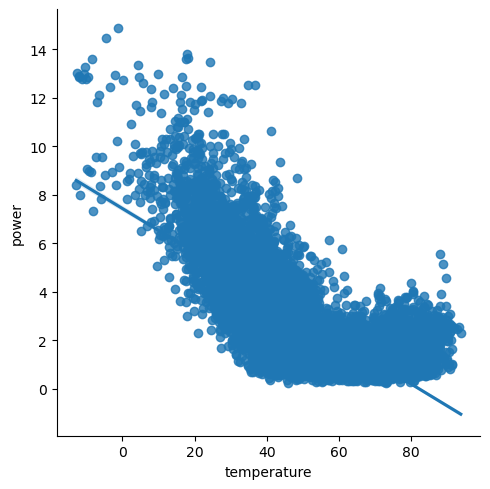

In [43]:
# sns.scatterplot(x=df['temperature'], y=df['power'])
ax = sns.lmplot(x="temperature", y="power", data=df)
ax.set_ylabels('power')
ax.set_xlabels('temperature')

In [45]:
df

,power,temperature
timestamp,,
2014-01-01 01:00:00,0.480605,19.22
2014-01-01 02:00:00,0.648437,18.10
2014-01-01 03:00:00,0.297454,17.47
2014-01-01 04:00:00,0.564292,15.63
2014-01-01 05:00:00,0.421209,15.33
...,...,...
2016-12-30 19:00:00,0.426538,35.94
2016-12-30 20:00:00,0.473570,38.08
2016-12-30 21:00:00,0.525701,36.65


In [50]:
df['temperature'].describe()

count    26279.000000
mean        49.279765
std         19.963686
min        -12.660000
25%         34.375000
50%         50.040000
75%         65.300000
max         93.960000
Name: temperature, dtype: float64